## ASSIGNMENT 5

Fraud: A how-to guide

Many cases of fraud can be detected through outlier detection or other statistical analysis. A fairly well-known example is Benford’s law: http://mathworld.wolfram.com/BenfordsLaw.html. This states that transactions amounts span several orders of magnitude and are best modeled in log-space. However when converted back into normal amounts, roughly 30% of the transactions will have an initial digit of “1”, and 17% will have an initial digit of “2” etc. This is very different from most people’s intuition that each digit should have an equal probability of occurring.

In this problem, you will use density modeling to try and ensure that there are no statistical irregularities in data that you have generated yourself.

1. Download the following data containing personal transactions over a period of several years: https://course-resources.minerva.kgi.edu/uploaded_files/mke/Y5GZpr/anonymized.csv
2. Now build the following density models for:
    - The number of transactions that occur in a single month.
    - The day in the month that a transaction will occur on.
    - Transaction size.
3. Create plots showing the distributions that you’ve created.
4. Sampling from these density models, create a fictitious month of personal transactions.
5. Explain what flaws still remain in your model that a forensic accountant might be able to find and determine that this was a fraudulent set of transactions.
6. (Optional) How well does the data follow Benford’s law?

### IMPORT AND CLEAN DATA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors.kde import KernelDensity

In [2]:
data = pd.read_csv ('anonymized.csv')
data['Month_Year'] = [data['Date'][i][2:] for i in range (len(data))]
data['Day'] = [data['Date'][i][:2] for i in range (len(data))]
data = data.drop(['Date'], axis = 1)
data = data[['Day','Month_Year', 'Amount']]
data.head()

,Day,Month_Year,Amount
0,25,May2016,54241.35
1,29,May2017,54008.83
2,30,Jun2017,54008.82
3,05,Jan2017,52704.37
4,23,Feb2017,52704.36


### DENSITY FUNCTION

In [3]:
def density(data, x_label, bandwidth):
    X = np.linspace(np.min(data), np.max(data), 500).reshape(-1,1)    
    
    #Plot the histogram
    plt.figure (figsize = (8,6))
    plt.hist(data, bins=10, density=True, alpha = 0.3)  
    
    #Plot the density function 
    for i in ['cosine', 'linear','gaussian']:
        kde = KernelDensity(kernel= i , bandwidth=bandwidth).fit(data)
        y = np.exp(kde.score_samples(X))
        plt.plot(X, y, label = '{} kernel'.format(i))
    plt.title("Density estimation of {}, bandwidth = {}".format(x_label, bandwidth))
    plt.xlabel(x_label)
    plt.ylabel("Density")
    plt.legend (loc = 'upper right')
    plt.show()
    return kde

### THE NUMBER OF TRANSACTION PER MONTH

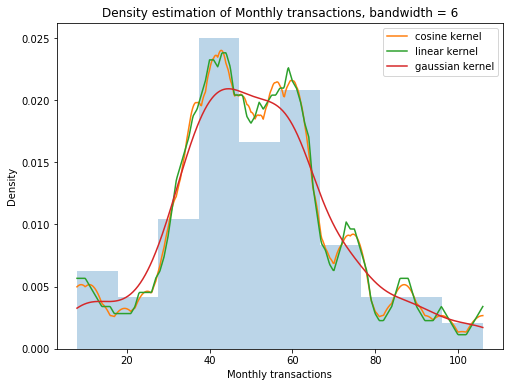

KernelDensity(algorithm='auto', atol=0, bandwidth=6, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [4]:
month = np.array(data['Month_Year'].value_counts()).reshape(-1,1)
month_density = density(month,'Monthly transactions', 6)
month_density

### THE NUMBER OF TRANSACTION IN A DAY

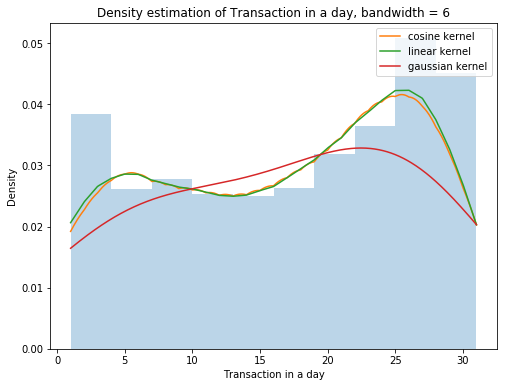

KernelDensity(algorithm='auto', atol=0, bandwidth=6, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [5]:
day = np.array(data['Day'], dtype = float).reshape(-1,1)
day_density = density(day, 'Transaction in a day', 6)
day_density

### TRANSACTION SIZE

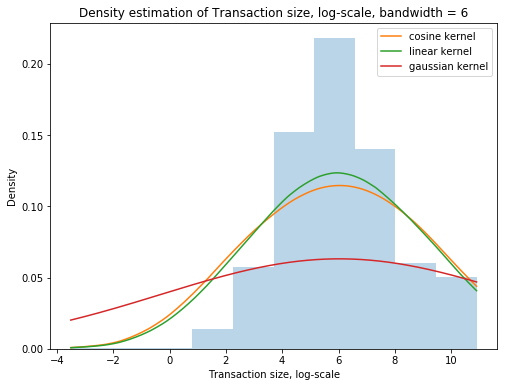

KernelDensity(algorithm='auto', atol=0, bandwidth=6, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [6]:
#The log model has strictly positive values
size = np.array(np.log(np.abs((data['Amount'])))).reshape(-1, 1)
density(size, 'Transaction size, log-scale', 6)

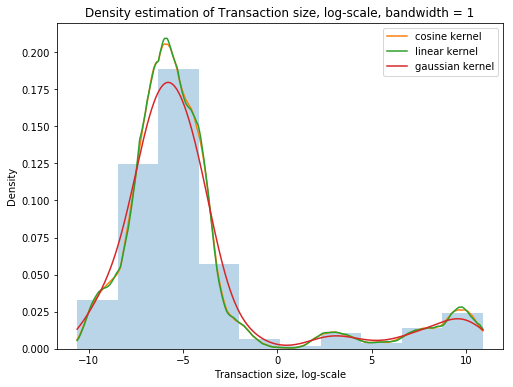

KernelDensity(algorithm='auto', atol=0, bandwidth=1, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [7]:
#Plotting the model with negative signs as well
size_2 = np.array(np.sign(data['Amount']) * np.log(np.abs((data['Amount'])))).reshape(-1, 1)
size_density = density(size_2, 'Transaction size, log-scale',1)
size_density

### SAMPLING FROM DENSITY MODELS

In [8]:
def sampling(month_density, day_density, size_density, n):
    
    #Sampling the days of the month (this month has 31 days) 
    days = (day_density.sample(n).astype(int) % 31) + 1
    days = days[:,0]
    
    #Sampling the transaction size for each day sample
    sizes = size_density.sample(n)[:,0]
    sizes = np.sign(sizes) * np.exp(np.abs(sizes)) #include the size of the data    
    
    #Create a dataframe
    result = pd.DataFrame(data=np.array([days, sizes]).T, columns = ['Day', 'Amount'])
    result['Amount'] = np.round(result['Amount'], 2)
    result['Day'] = np.round(result['Day']).astype(int)
    result = result.sort_values('Day')
    result = result.reset_index()
    result = result.drop(columns='index')
    return result

In [9]:
fake_data = sampling(month_density,day_density, size_density, 10000)
fake_data.head()

,Day,Amount
0,1,-359.93
1,1,-435.04
2,1,-654.77
3,1,-3369.52
4,1,-50.70


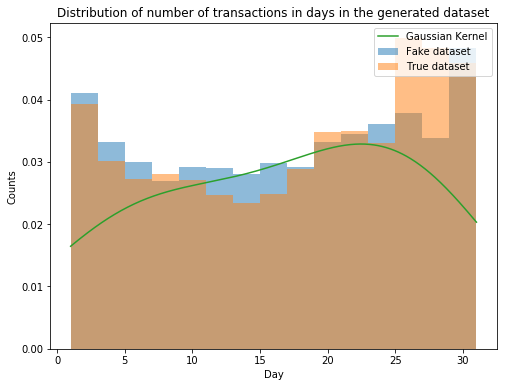

In [10]:
#Compare the generated dataset with the real dataset and Kernel Density function

#Plot the histogram of fake data
plt.figure (figsize = (8,6))
plt.hist(fake_data['Day'], bins=15, alpha=.5, density = True, label = 'Fake dataset')

#Plot the histogram of the true data 
plt.hist(day, bins=15, alpha=.5, density = True, label = 'True dataset')

#Plot the Kernel Function
x = np.linspace(1, 31, 500).reshape(-1,1)    
y = np.exp(day_density.score_samples(x))
plt.plot(x, y, label = 'Gaussian Kernel')
plt.title("Distribution of number of transactions in days in the generated dataset")
plt.xlabel('Day')
plt.ylabel('Counts')
plt.legend (loc = 'upper right')
plt.show()

In [11]:
n = month_density.sample().astype(int)[0][0]
fake_data_2 = sampling(month_density,day_density, size_density, n)
fake_data_2.head()

,Day,Amount
0,1,-3640.39
1,1,-31.96
2,1,-494.21
3,2,-33.24
4,2,-282.41


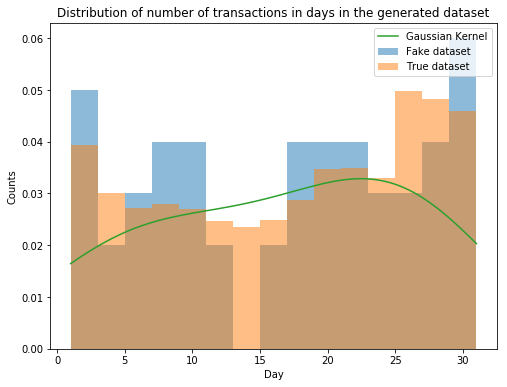

In [12]:
#Compare the generated dataset with the real dataset and Kernel Density function

#Plot the histogram of fake data
plt.figure (figsize = (8,6))
plt.hist(fake_data_2['Day'], bins=15, alpha=.5, density = True, label = 'Fake dataset')

#Plot the histogram of the true data 
plt.hist(day, bins=15, alpha=.5, density = True, label = 'True dataset')

#Plot the Kernel Function
x = np.linspace(1, 31, 500).reshape(-1,1)    
y = np.exp(day_density.score_samples(x))
plt.plot(x, y, label = 'Gaussian Kernel')
plt.title("Distribution of number of transactions in days in the generated dataset")
plt.xlabel('Day')
plt.ylabel('Counts')
plt.legend (loc = 'upper right')
plt.show()

In [13]:
len(fake_data_2)

50

### Benford's Law

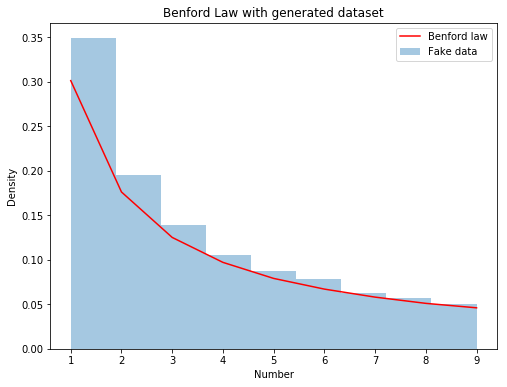

In [17]:
#Benford law distribution of first digit. Source: Wikipedia
Benford = [0.301, 0.176, 0.125, 0.097, 0.079, 0.067, 0.058, 0.051, 0.046]

#Number of digit in fake dataset
Benford_fake = [int(str(abs(i))[0]) for i in fake_data['Amount']]
    
#Compare the first digit of the fake dataset and Benford's law
plt.figure (figsize = (8,6))
x = [i for i in range (1,10)]
plt.plot (x, Benford, color = 'r', label = 'Benford law')
plt.hist (Benford_fake, alpha = 0.4, label ='Fake data', density = True, bins = 9)
plt.title ('Benford Law with generated dataset')
plt.xlabel ('Number')
plt.ylabel ('Density')
plt.legend (loc = 'upper right')
plt.show()